# Прогнозирование оттока клиентов для оператора связи

Построим модель машинного обучения для бинарной классификации для прогнозирования оттока клиентов.

Оператор предоставляет два типа услуг:
- Стационарную телефонную связь.Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: 
    - через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия»)
    - оптоволоконный кабель(Fiber optic).
    
    
Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection)
- Блокировка небезопасных сайтов (OnlineSecurity)
- Выделенная линия технической поддержки (TechSupport)
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup)
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies)

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

from catboost import CatBoostClassifier, Pool

RS = 42

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)   # видны все столбцы
pd.set_option('display.max_rows', None)      # и строки

## Знакомство с данными

In [3]:
# Загрузка данных

contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

data = [contract, personal, internet, phone]
data_name = ['contract', 'personal', 'internet', 'phone']

Описание файлов:

Данные состоят из файлов, полученных из разных источников. Во всех файлах столбец customerID содержит код клиента.

- contract_new.csv — информация о договоре
    - BeginDate - дата, с которой клиент начал пользоваться услугами компании
    - EndDate - дата, с которой клиент перестал пользоваться услугами компании (No - клиент на данный момент пользуется услугами компании)
    - Type - периодичность оплаты
    - PaperlessBilling - выставление бумажного счета
    - PaymentMethod - способ оплаты
    - MonthlyCharges - сумма ежемесячного платежа
    - TotalCharges - итоговая сумма, которую заплатил клиент, пользуясь услугами компании  
    
    
- personal_new.csv — персональные данные клиента
    - gender - пол клиента
    - SeniorCitizen - наличие пенсионного статуса
    - Partner - наличие партнера
    - Dependents - наличие иждевенцев
    
    
- internet_new.csv — информация об интернет-услугах
    - InternetService - тип подключения интернета
    - OnlineSecurity - наличие услуги по блокировкае небезопасных сайтов
    - OnlineBackup - наличие услуги облачного хранилища файлов для резервного копирования данных
    - DeviceProtection - наличие услуги антивируса
    - TechSupport - наличие выделенной линии технической поддержки
    - StreamingTV - наличие услуги стримингового телефидения
    - StreamingMovies - наличие услуги каталога фильмов
    
    
- phone_new.csv — информация об услугах телефонии
    - MultipleLines - наличие параллельных линий (телефонная связь)


Информация о договорах актуальна на 1 февраля 2020.

In [4]:
for i in range(len(data)):
    print('\033[1m' + data_name[i] + '\033[0m')
    display(data[i].head())
    data[i].info()
    print()

contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB



In [5]:
# Изучение уникальных значений в каждом из столбцов

for i in range(len(data)):
    for index in data[i].columns:
        if index != 'customerID':
            print('\033[1m' + index + '\033[0m')
            print(data[i][str(index)].unique())
            print()

BeginDate
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014-06-01' '2017-01-01'
 '2015-07-01' '2020-02-01' '2016-11-01' '2013-11-01' '2014-01-01'


In [6]:
# Изучение явных пропущенных значений

for i in range(len(data)):
    print('\033[1m' + data_name[i] + '\033[0m')
    print(data[i].isna().sum())
    print()

contract
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

personal
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

internet
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

phone
customerID       0
MultipleLines    0
dtype: int64



In [7]:
# Изучение дубликатов

for i in range(len(data)):
    print('\033[1m' + data_name[i] + '\033[0m')
    display(data[i].groupby('customerID').count().iloc[:,0].sort_values(ascending=False).head())

contract


customerID
0002-ORFBO    1
6616-AALSR    1
6625-UTXEW    1
6625-IUTTT    1
6625-FLENO    1
Name: BeginDate, dtype: int64

personal


customerID
0002-ORFBO    1
6616-AALSR    1
6625-UTXEW    1
6625-IUTTT    1
6625-FLENO    1
Name: gender, dtype: int64

internet


customerID
0002-ORFBO    1
6620-JDYNW    1
6631-HMANX    1
6630-UJZMY    1
6629-LADHQ    1
Name: InternetService, dtype: int64

phone


customerID
0002-ORFBO    1
6625-IUTTT    1
6621-YOBKI    1
6621-NRZAK    1
6620-JDYNW    1
Name: MultipleLines, dtype: int64

Объединим все таблицы в одну (data_total) для построения модели машинного обучения. Объединять будем через тип объединения 'outer', чтобы не упустить ни одного пользователя.

В дальнейшем будем работать с ней.

In [8]:
data_total = contract.merge(personal, on='customerID', how='outer')
data_total = data_total.merge(internet, on='customerID', how='outer')
data_total = data_total.merge(phone, on='customerID', how='outer')
    
display(data_total.head())
data_total.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Посмотрим на количество пропусков в итоговой таблице.

In [9]:
data_total.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

## Подготовка и исследовательский анализ данных

Изменим тип данных в столбце BeginDate с object на datetime:

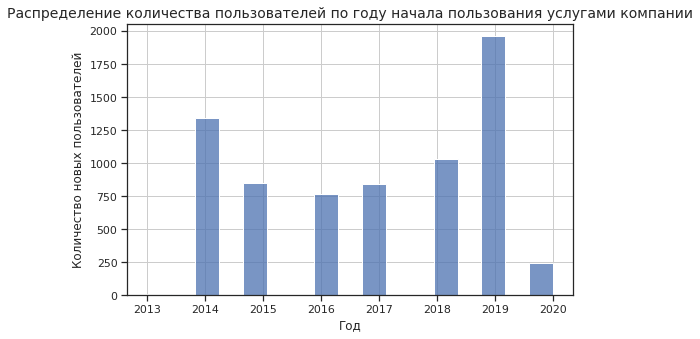

In [10]:
data_total['BeginDate'] = pd.to_datetime(data_total['BeginDate'], format='%Y-%m-%d')

sns.set_theme(style="ticks")

plt.figure(figsize=(8,5))
ax = sns.histplot(data_total['BeginDate'].dt.year)
ax.set_title('Распределение количества пользователей по году начала пользования услугами компании', fontsize=14)
ax.set(xlabel='Год',
       ylabel='Количество новых пользователей')
plt.grid()

Данные компании начинаются с 2013 года, далее каждый год количество клиентов понемногу растет. Большой скачок наблюдается в 2019 году.

Количество клиентов компании =  5174


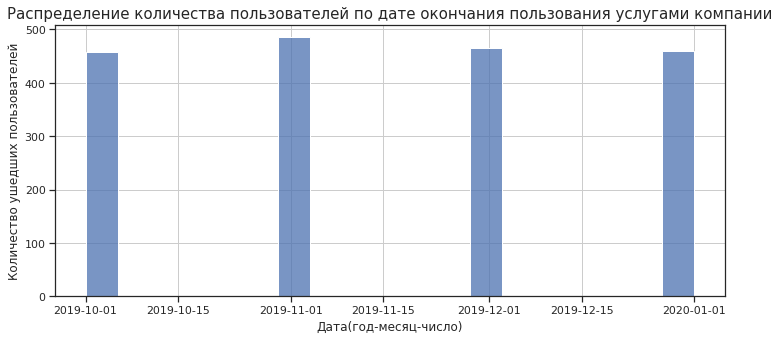

In [11]:
plt.figure(figsize=(12,5))
ax = sns.histplot(pd.to_datetime(data_total.loc[data_total['EndDate'] != 'No', 'EndDate'], format='%Y-%m-%d'))
ax.set_title('Распределение количества пользователей по дате окончания пользования услугами компании', fontsize=15)
ax.set(xlabel='Дата(год-месяц-число)',
       ylabel='Количество ушедших пользователей')
plt.grid()

print('Количество клиентов компании = ', data_total.loc[data_total['EndDate'] == 'No', 'EndDate'].count())

C октября 2019 года каждый месяц начали уходить пользователи (400-500 человек). На дату выгрузки клиентами компании остаются 5174 человека. Будем делать предсказания для этой группы людей на дату выгрузки данных - 1 февраля 2020.

Минимальное значение ежемесячного платежа (за все время) = 18.25
Максимальное значение ежемесячного платежа (за все время) = 118.75


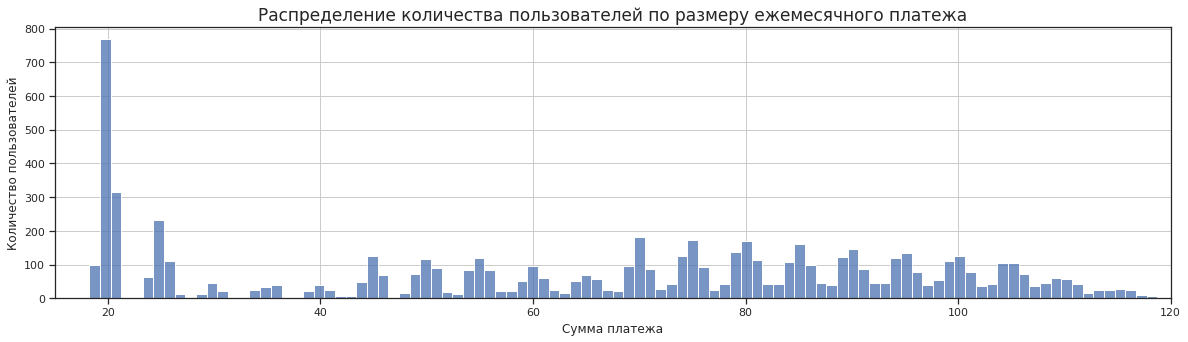

In [12]:
plt.figure(figsize=(20,5))
ax = sns.histplot(data_total['MonthlyCharges'], bins=100)
ax.set(xlim=(15,120))
ax.set_title('Распределение количества пользователей по размеру ежемесячного платежа', fontsize=17)
ax.set(xlabel='Сумма платежа',
       ylabel='Количество пользователей')
plt.grid()

print('Минимальное значение ежемесячного платежа (за все время) =', data_total['MonthlyCharges'].min())
print('Максимальное значение ежемесячного платежа (за все время) =', data_total['MonthlyCharges'].max())

Больше всего клиентов ежемесячно приносят компании по 20-25 денежных единиц.  

In [13]:
data_total.query('TotalCharges == " " ')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


В столбце есть несколько значений, где нет итоговой суммы. Это связано с тем, что пользователи стали клиентами компании в день выгрузки данных. Заполним столбец 'TotalCharges' значением ежемесячного платежа.

In [14]:
data_total.loc[data_total['TotalCharges'] == " ", 'TotalCharges'] = data_total['MonthlyCharges']

Изменим тип данных в столбце 'TotalCharges' с object на float и построим гистрограмму.

Минимальное значение трат (за все время) = 18.8
Максимальное значение трат (за все время) = 8684.8


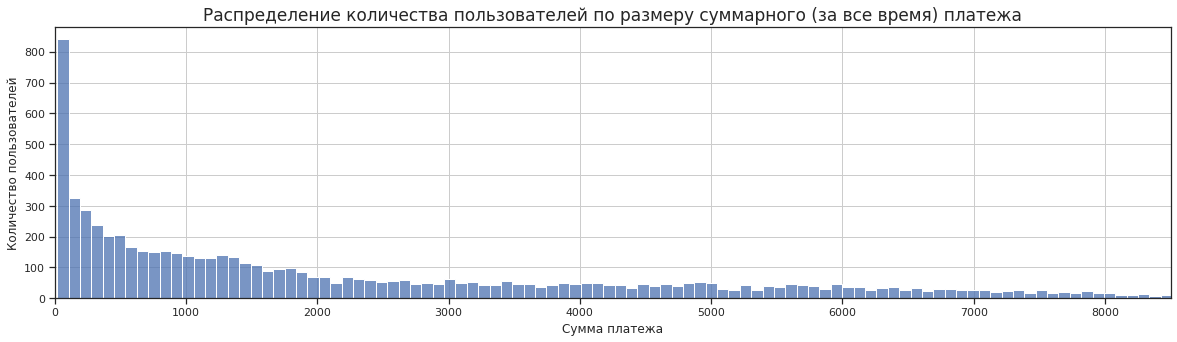

In [15]:
data_total['TotalCharges'] = data_total['TotalCharges'].astype('float')

plt.figure(figsize=(20,5))
ax = sns.histplot(data_total['TotalCharges'], bins=100)
ax.set(xlim=(0,8500))
ax.set_title('Распределение количества пользователей по размеру суммарного (за все время) платежа', fontsize=17)
ax.set(xlabel='Сумма платежа',
       ylabel='Количество пользователей')
plt.grid()
print('Минимальное значение трат (за все время) =', data_total['TotalCharges'].min())
print('Максимальное значение трат (за все время) =', data_total['TotalCharges'].max())

Здесь также большое количество пользователей с небольшими годовыми платежами. Что логично - им соответствуют небольшие ежемесячные платежи.

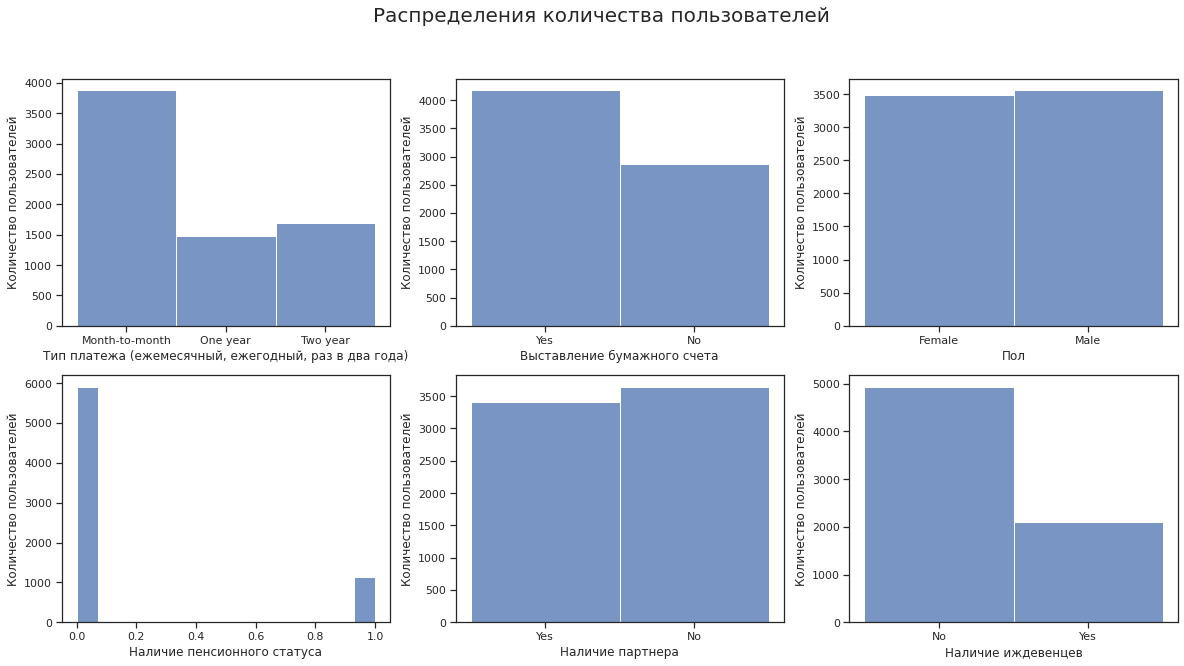

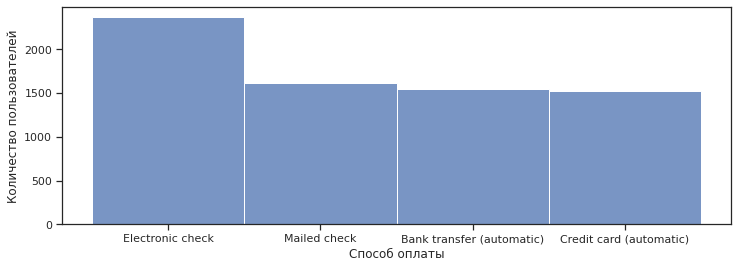

In [16]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
fig.suptitle('Распределения количества пользователей', fontsize=20)

ax1 = sns.histplot(data_total['Type'], ax=axes[0,0])
ax1.set(xlabel='Тип платежа (ежемесячный, ежегодный, раз в два года)',
       ylabel='Количество пользователей')

ax2 = sns.histplot(data_total['PaperlessBilling'], ax=axes[0,1])
ax2.set(xlabel='Выставление бумажного счета',
        ylabel='Количество пользователей')

ax3 = sns.histplot(data_total['gender'], ax=axes[0,2])
ax3.set(xlabel='Пол',
        ylabel='Количество пользователей')

ax4 = sns.histplot(data_total['SeniorCitizen'], ax=axes[1,0])
ax4.set(xlabel='Наличие пенсионного статуса',
        ylabel='Количество пользователей')

ax5 = sns.histplot(data_total['Partner'], ax=axes[1,1])
ax5.set(xlabel='Наличие партнера',
        ylabel='Количество пользователей')

ax6 = sns.histplot(data_total['Dependents'], ax=axes[1,2])
ax6.set(xlabel='Наличие иждевенцев',
        ylabel='Количество пользователей');

plt.figure(figsize=(12,4))
ax7 = sns.histplot(data_total['PaymentMethod'])
ax7.set(xlabel='Способ оплаты',
        ylabel='Количество пользователей');

Иходя из графиков, можно заключить, что около половины людей платят за услуги каждый месяц, четверть ежегодно и еще четверть каждые два года. 

Мужчин и женщин примерно одинаковое кол-во. Также примерно поровну тех, кто имеет и не имеею партнера. 

Большинство клиентов (>80%) не имеют пенсионного статуса, кроме того у ~70% клиентов нет иждевенцев.



Далее рассмотрим столбец MultipleLines.
Здесь есть пропуски. Выведем все строки, где этот столбец не заполнен.

In [17]:
data_total.loc[data_total['MultipleLines'].isnull() == True].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
20,8779-QRDMV,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,39.65,39.65,Male,1,No,No,DSL,No,No,Yes,No,No,Yes,NaN
27,8665-UTDHZ,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Electronic check,30.20,30.20,Male,0,Yes,Yes,DSL,No,Yes,No,No,No,No,NaN


Тип интернет соединения в каждой строчке, где не заполнено наличие возможности ведения параллельных линий, - телефонная линия (DSL). Рассмотрим, чуть подробнее типы подключения.

In [18]:
print('Тип соединения DSL и возможность проведения параллельных линий (кол-во пользователей) -',
      data_total.query('InternetService == "DSL" & MultipleLines == "Yes"')['MultipleLines'].count())
print('Тип соединения DSL и отсутствие возможности проведения параллельных линий (кол-во пользователей) -',
      data_total.query('InternetService == "DSL" & MultipleLines == "No"')['MultipleLines'].count())

print('Тип соединения Fiber optic и возможность проведения параллельных линий (кол-во пользователей) -',
      data_total.query('InternetService == "Fiber optic" & MultipleLines == "Yes"')['MultipleLines'].count())
print('Тип соединения Fiber optic и отсутствие возможности проведения параллельных линий (кол-во пользователей) -',
      data_total.query('InternetService == "Fiber optic" & MultipleLines == "No"')['MultipleLines'].count())

Тип соединения DSL и возможность проведения параллельных линий (кол-во пользователей) - 691
Тип соединения DSL и отсутствие возможности проведения параллельных линий (кол-во пользователей) - 1048
Тип соединения Fiber optic и возможность проведения параллельных линий (кол-во пользователей) - 1938
Тип соединения Fiber optic и отсутствие возможности проведения параллельных линий (кол-во пользователей) - 1158


Как таковой зависимсти я здесь не вижу, скорее всего для части пользователей просто забыли заполнить столбец MultipleLines. Заполним пропущенные значения типом 'unknown', так как удалить почти 10% пользователей мы не можем, а четкая зависимось обнаружена не была и рандомное заполнение не правомерно.

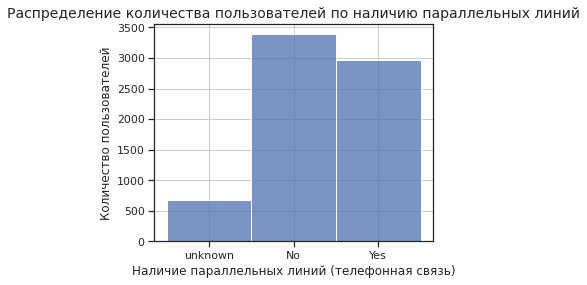

In [19]:
data_total.loc[data_total['MultipleLines'].isnull() == True, 'MultipleLines'] = 'unknown'

plt.figure(figsize=(5,4))
ax = sns.histplot(data_total['MultipleLines'])
ax.set_title('Распределение количества пользователей по наличию параллельных линий', fontsize=14)
ax.set(xlabel='Наличие параллельных линий (телефонная связь)',
       ylabel='Количество пользователей')
plt.grid()

Далее рассмотрим столбец InternetService и выведем строчки, где значения не заполнены.

In [20]:
data_total.loc[data_total['InternetService'].isnull() == True].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
11,7469-LKBCI,2018-10-01,No,Two year,No,Credit card (automatic),18.95,326.80,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
16,8191-XWSZG,2015-10-01,No,One year,No,Mailed check,20.65,1022.95,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
21,1680-VDCWW,2019-02-01,No,One year,No,Bank transfer (automatic),19.80,202.25,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
22,1066-JKSGK,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,20.15,20.15,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
33,7310-EGVHZ,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,20.20,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


Если изучить все объекты из выборки выше, то видно, что если не заполнен столбец, где указано наличие интернет-соединения, то не заполнены столбцы блокировка небезопасных сайтов, облачное хранилище, антивирус, стриминговое телевидение и каталог фильмов.

Мне кажется, это значит, что интернет не подключен, соответственно не подключены и все эти сервисы. Заполним все недостающие значения в этих столбцах на 'No'.

In [21]:
data_total = data_total.fillna('No')

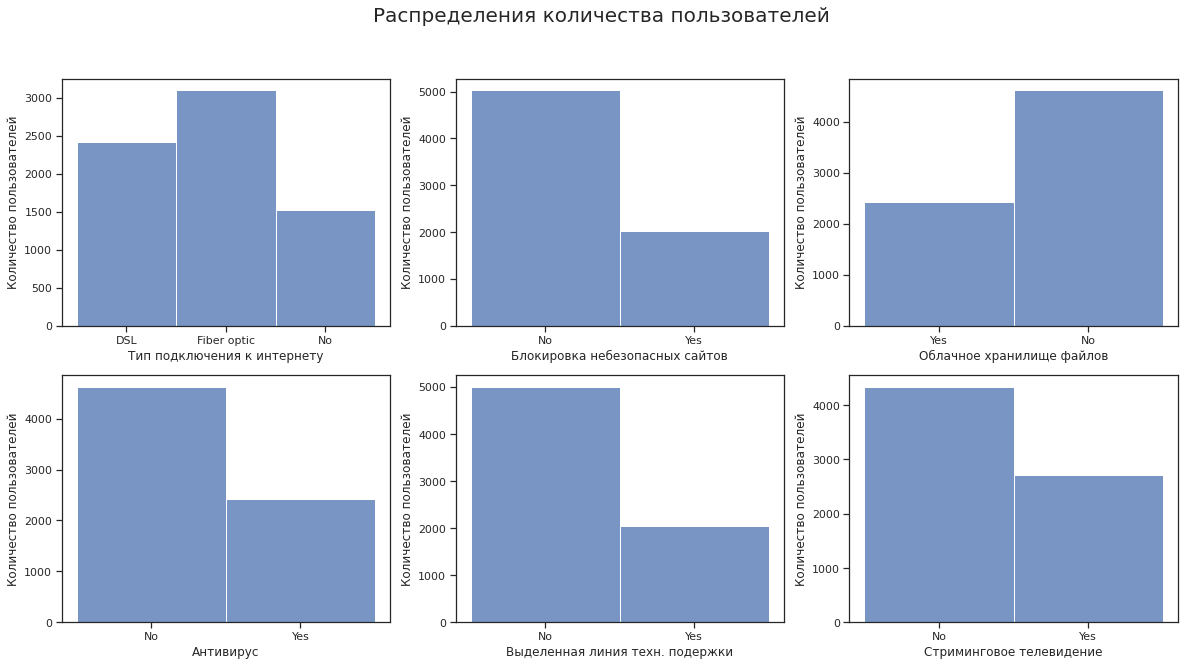

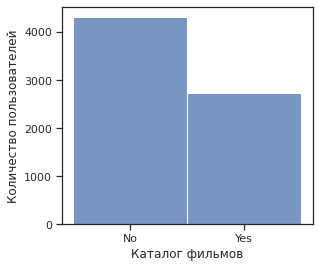

In [22]:
internet_col = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']

fig, axes = plt.subplots(2,3, figsize=(20,10))
fig.suptitle('Распределения количества пользователей', fontsize=20)

ax1 = sns.histplot(data_total['InternetService'], ax=axes[0,0])
ax1.set(xlabel='Тип подключения к интернету',
       ylabel='Количество пользователей')

ax2 = sns.histplot(data_total['OnlineSecurity'], ax=axes[0,1])
ax2.set(xlabel='Блокировка небезопасных сайтов',
       ylabel='Количество пользователей')

ax3 = sns.histplot(data_total['OnlineBackup'], ax=axes[0,2])
ax3.set(xlabel='Облачное хранилище файлов',
       ylabel='Количество пользователей')

ax4 = sns.histplot(data_total['DeviceProtection'], ax=axes[1,0])
ax4.set(xlabel='Антивирус',
       ylabel='Количество пользователей')

ax5 = sns.histplot(data_total['TechSupport'], ax=axes[1,1])
ax5.set(xlabel='Выделенная линия техн. подержки',
       ylabel='Количество пользователей')

ax6 = sns.histplot(data_total['StreamingTV'], ax=axes[1,2])
ax6.set(xlabel='Стриминговое телевидение',
       ylabel='Количество пользователей')

plt.figure(figsize=(4.5,4))
ax7 = sns.histplot(data_total['StreamingMovies'])
ax7.set(xlabel='Каталог фильмов',
       ylabel='Количество пользователей');

In [23]:
print('Кол-во пользователей с типом интернет-соединения DSL =',
      data_total.query('InternetService == "DSL"')['InternetService'].count())
print('Кол-во пользователей с типом интернет-соединения Fiber optic =',
      data_total.query('InternetService == "Fiber optic"')['InternetService'].count())

Кол-во пользователей с типом интернет-соединения DSL = 2421
Кол-во пользователей с типом интернет-соединения Fiber optic = 3096


Около 44 % пользователей, указавших тип интернет-соединения выбирают DSL, остальные ~56% - Fiber optic.

Услугами, связанными с интернетом пользуется от 30 до 40% пользователей (в зависимости от услуги).

## Промежуточные выводы

Данные были загружены, объединены в одну таблицу и проанализированы.

1. В столбцах BeginDate и EndDate был изменен тип данных с object на datetime.   
2. В столбце TotalCharges были заполнены пропущенные значения. Они были связаны с клиентами, присоединившимися к компании в день выгрузки данных. Также был заменен тип данных с object на float.
3. В столбце MultipleLines не было найдено закономерностей для пропущенных значений и пропуски были обозначены типом 'unknown' (около 10%). 
4. В столбцах, связанных с интернет-соединением все пропуски были заменены на 'No', так как вероятнее всего у пользователей, не пользующихся интернетом просто не заполнили данную графу.


Данные компании представлены с 2013 года. Кажый год количество клиентов понемногу росло. Большой скачок наблюдался в 2019 году, с октября 2019 года каждый месяц начали уходить пользователи (400-500 человек). 

Будем делать предсказание - уйдет клиент из компании или нет на датц выгрузки данных 1 февраля 2020 года.

Для этого планируется разделить данные на тренировочный (75%) и тестовый датасеты (25%). Деление будет происходить со стратификацией. Затем данные будут закодированы (для классических алгоритмов). Будут строиться модели логистической регрессии и случайного леса. Также буду использовать CatBoost, предваритеьно указав какие признаки категориальные, а какие количественные.
Качество бинарной классификации будем смотреть на auc-roc, после чего будет выбираться лучшая модель и тестироваться на тестовой выборке. Итоговый показатель по заданию заказчика должен быть выше 0.85.

## Подготовка к построению модели

Cоздадим столбец target на основе столбца EndDate: 1 - пользователь ушел (есть дата в столбце EndDate) и пользователь пользуется услугами компании на данный момент (No в столбце EndDate).

In [24]:
data_total.loc[data_total['EndDate'] != 'No', 'target'] = 1
data_total.loc[data_total['EndDate'] == 'No', 'target'] = 0

Создадим дополнительный признак.

Для этого сначала вместо даты ухода клиента поставим заглушку - 1 февраля 2020 (дату выгрузки данных). Затем получим кол-во дней, которое клиент пользовался услугами компании.

In [25]:
data_total.loc[data_total['EndDate'] == 'No', 'EndDate'] = '2020-02-01 00:00:00'
data_total['EndDate'] = pd.to_datetime(data_total['EndDate'], format='%Y-%m-%d %H:%M:%S')

data_total['delta'] = data_total['EndDate'] - data_total['BeginDate']
data_total['delta'] = data_total['delta'].dt.days

Удалим столбцы BeginDate и EndDate.

In [26]:
data_total = data_total.drop(['BeginDate', 'EndDate'], axis=1)

Поделим данные на тренировочный и тестовый датасеты.

In [27]:
features = data_total.drop(['target', 'customerID'], axis=1)
target = data_total['target']

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25,
                                                                            random_state=RS,
                                                                            stratify=target)

Проверим, насколько корректно данные разделились на выборки

In [28]:
print('Процент ушедших из компании пользователей в тренировочной выборке = {:.0%}'.format(target_train.sum()/target_train.count()))
print('Процент ушедших из компании пользователей в тестовой выборке = {:.0%}'.format(target_test.sum()/target_test.count()))

Процент ушедших из компании пользователей в тренировочной выборке = 27%
Процент ушедших из компании пользователей в тестовой выборке = 27%


Скопируем датафреймы для кодирования категориальных признаков

In [29]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

Закодируем категориальные признаки (OneHotEncoder)

In [30]:
columns_ohe = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 
               'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
               'StreamingTV', 'StreamingMovies', 'MultipleLines']

encoder_ohe = OneHotEncoder()
encoder_ohe.fit(features_train_ohe[columns_ohe])

features_ohe_train = pd.DataFrame(encoder_ohe.transform(features_train_ohe[columns_ohe]).toarray(),
                                  index=features_train_ohe.index)
features_ohe_test = pd.DataFrame(encoder_ohe.transform(features_test_ohe[columns_ohe]).toarray(),
                                 index=features_test_ohe.index)

features_ohe_train.columns = encoder_ohe.get_feature_names(columns_ohe)
features_ohe_test.columns = encoder_ohe.get_feature_names(columns_ohe)

features_train_ohe = pd.concat([features_train_ohe, features_ohe_train], axis=1)
features_test_ohe = pd.concat([features_test_ohe, features_ohe_test], axis=1)

features_train_ohe = features_train_ohe.drop(columns_ohe, axis=1)
features_test_ohe = features_test_ohe.drop(columns_ohe, axis=1)

Посмотрим на данные после кодирования

In [31]:
features_train_ohe.head()

,MonthlyCharges,TotalCharges,delta,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_No,MultipleLines_Yes,MultipleLines_unknown
6661,53.65,3784.00,2191,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4811,46.00,193.60,122,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2193,21.20,1238.65,1706,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1904,94.45,5124.60,1706,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6667,79.55,723.40,275,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


## Построение моделей

Будем работать с тремя моделями - LogisticRegression, RandomForestClassifier и CatBoostClassifier, подбирать гиперпараметры с помощью GridSearch.

### Логистическая регрессия

In [32]:
%%time

model_LR = LogisticRegression(random_state=RS, max_iter=200)
parameters_LR = {'C':[1,10], 'solver':['liblinear']} 
grid_LR = GridSearchCV(model_LR, parameters_LR, cv=5, scoring='roc_auc')
grid_LR.fit(features_train_ohe, target_train)

print('Лучшие параметры модели = ', grid_LR.best_params_)
print('ROC-AUC модели =', grid_LR.best_score_.round(2))

Лучшие параметры модели =  {'C': 1, 'solver': 'liblinear'}
ROC-AUC модели = 0.84
CPU times: user 1.13 s, sys: 1.03 s, total: 2.16 s
Wall time: 2.17 s


### RandomForestClassifier

In [33]:
%%time

model_forest = RandomForestClassifier(random_state=RS) 
parameters_forest = {'n_estimators':[1,1000,50], 'max_depth':[1,12]}
grid_forest = GridSearchCV(model_forest, parameters_forest, cv=3, scoring='roc_auc')
grid_forest.fit(features_train_ohe, target_train)

print('Лучшие параметры модели = ', grid_forest.best_params_)
print('ROC-AUC модели =', grid_forest.best_score_.round(2)) 

Лучшие параметры модели =  {'max_depth': 12, 'n_estimators': 1000}
ROC-AUC модели = 0.85
CPU times: user 22.2 s, sys: 270 ms, total: 22.4 s
Wall time: 22.5 s


### CatBoostClassifier

In [34]:
%%time

model_CBC = CatBoostClassifier(random_state=RS, verbose=100, eval_metric='AUC:hints=skip_train~false',
                               cat_features=['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
                                             'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
                                             'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                                             'StreamingMovies', 'MultipleLines'])
parameters_CBC = {'depth':[1,10], 'n_estimators':[0,2000], 'learning_rate':[1]}
grid_CBC = GridSearchCV(model_CBC, parameters_CBC, cv=3, scoring='roc_auc')
grid_CBC.fit(features_train, target_train)

print('Лучшие параметры модели = ', grid_CBC.best_params_)
print('ROC-AUC модели =', grid_CBC.best_score_.round(2))

0:	learn: 0.6649553	total: 49.1ms	remaining: 1m 38s
100:	learn: 0.8845338	total: 234ms	remaining: 4.4s
200:	learn: 0.8969066	total: 427ms	remaining: 3.82s
300:	learn: 0.9034954	total: 610ms	remaining: 3.44s
400:	learn: 0.9085346	total: 792ms	remaining: 3.16s
500:	learn: 0.9121948	total: 972ms	remaining: 2.91s
600:	learn: 0.9164109	total: 1.15s	remaining: 2.68s
700:	learn: 0.9189416	total: 1.33s	remaining: 2.47s
800:	learn: 0.9216427	total: 1.52s	remaining: 2.28s
900:	learn: 0.9237631	total: 1.71s	remaining: 2.08s
1000:	learn: 0.9258453	total: 1.89s	remaining: 1.89s
1100:	learn: 0.9278743	total: 2.08s	remaining: 1.7s
1200:	learn: 0.9296659	total: 2.26s	remaining: 1.51s
1300:	learn: 0.9310051	total: 2.45s	remaining: 1.31s
1400:	learn: 0.9324340	total: 2.63s	remaining: 1.12s
1500:	learn: 0.9337153	total: 2.81s	remaining: 933ms
1600:	learn: 0.9347976	total: 2.98s	remaining: 744ms
1700:	learn: 0.9363800	total: 3.17s	remaining: 557ms
1800:	learn: 0.9374528	total: 3.35s	remaining: 371ms
1900:

Сравним модели

In [35]:
column=['ROC-AUC модели']

result = pd.DataFrame(index=column,
                      columns=['LogisticRegression','RandomForestClassifier',
                                'CatBoostClassifier'])
result['LogisticRegression'] = grid_LR.best_score_.round(2)
result['RandomForestClassifier'] = grid_forest.best_score_.round(2)
result['CatBoostClassifier'] = grid_CBC.best_score_.round(2) 

result

,LogisticRegression,RandomForestClassifier,CatBoostClassifier
ROC-AUC модели,0.84,0.85,0.9


Из таблицы можно увидеть, что лучшая модель - CatBoostClassifier. Будем тестировать ее.

## Тестирование модели

In [36]:
model_CBC = CatBoostClassifier(random_state=RS, verbose=100, depth=1, n_estimators=2000, learning_rate=1, 
                               eval_metric='AUC:hints=skip_train~false', custom_loss=['AUC'],
                               cat_features=['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
                                             'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
                                             'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                                             'StreamingMovies', 'MultipleLines'])
model_CBC.fit(features_train, target_train, plot=True) 
predictions_test_cat = model_CBC.predict(features_test)

probabilities_test_cat = model_CBC.predict_proba(features_test)
probabilities_one_test_cat = probabilities_test_cat[:, 1]
auc_roc_cat = roc_auc_score(target_test, probabilities_one_test_cat)

print('auc-roc на тестовой выборке =', auc_roc_cat.round(2))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6733519	total: 2.58ms	remaining: 5.16s
100:	learn: 0.8828856	total: 280ms	remaining: 5.25s
200:	learn: 0.8935017	total: 544ms	remaining: 4.87s
300:	learn: 0.8992087	total: 809ms	remaining: 4.57s
400:	learn: 0.9031652	total: 1.06s	remaining: 4.25s
500:	learn: 0.9070768	total: 1.33s	remaining: 3.97s
600:	learn: 0.9101701	total: 1.61s	remaining: 3.74s
700:	learn: 0.9127636	total: 1.91s	remaining: 3.54s
800:	learn: 0.9152748	total: 2.2s	remaining: 3.29s
900:	learn: 0.9172103	total: 2.5s	remaining: 3.05s
1000:	learn: 0.9189356	total: 2.77s	remaining: 2.76s
1100:	learn: 0.9218046	total: 3.04s	remaining: 2.48s
1200:	learn: 0.9236271	total: 3.32s	remaining: 2.21s
1300:	learn: 0.9255431	total: 3.6s	remaining: 1.93s
1400:	learn: 0.9271210	total: 3.87s	remaining: 1.65s
1500:	learn: 0.9289097	total: 4.17s	remaining: 1.38s
1600:	learn: 0.9304179	total: 4.43s	remaining: 1.1s
1700:	learn: 0.9323064	total: 4.7s	remaining: 827ms
1800:	learn: 0.9334172	total: 4.97s	remaining: 550ms
1900:	lea

Построим ROC кривую и матрицу ошибок.

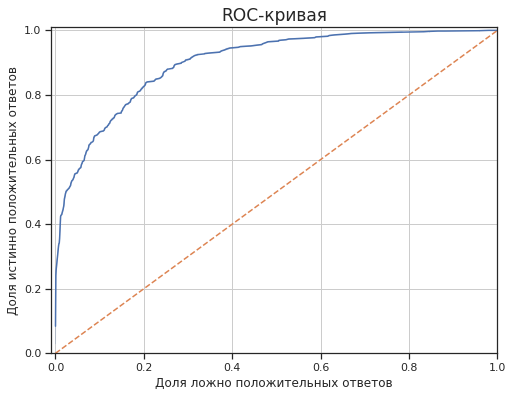

In [37]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_cat)
plt.figure(figsize=(8,6))
ax = sns.lineplot(fpr,tpr)
ax = sns.lineplot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
ax.set(xlim=(-0.01, 1.0))
ax.set(ylim=(0.0, 1.01))
ax.set_title('ROC-кривая', fontsize=17)
ax.set(xlabel='Доля ложно положительных ответов',
       ylabel='Доля истинно положительных ответов')
plt.grid();

На графике изображена ROC-кривая нашей модели и кривая модели, которая отвечает случайно (пунктирная линия). Она сильно выше случайной модели, что говорит о неплохом качестве предсказаний нашей модели CatBoost.

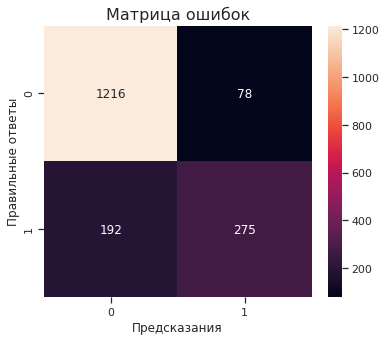

In [38]:
plt.figure(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(target_test, predictions_test_cat), 
                 annot=True,
                 fmt='d')
ax.set_title('Матрица ошибок', fontsize=16)
ax.set(xlabel='Предсказания',
       ylabel='Правильные ответы');

Исходя из матицы ошибок, видно, что 1491 ответов мы предсказали верно. 198 человек (FN) ушли из компании, хотя мы предсказали, что они останутся, а 78 человек (FP) наоборот - остались, хотя мы предсказали, что они покинут компанию. 

Получается, что в зависимости от того, что будет важнее для компании - не потерять клиента или не раздать лишних промокодов (для тех, кто собирается уйти), мы сможем подобрать наилучший порог. 

## Важность признаков моделей

Проведем анализ важности признаков лучшей модели

,Feature Id,Importances
0,delta,57.097439
1,InternetService,13.919382
2,Type,10.355409
3,TotalCharges,6.804104
4,MonthlyCharges,4.677785
5,MultipleLines,1.961945
6,StreamingMovies,1.930651
7,PaperlessBilling,1.468526
8,PaymentMethod,0.877107
9,StreamingTV,0.254845


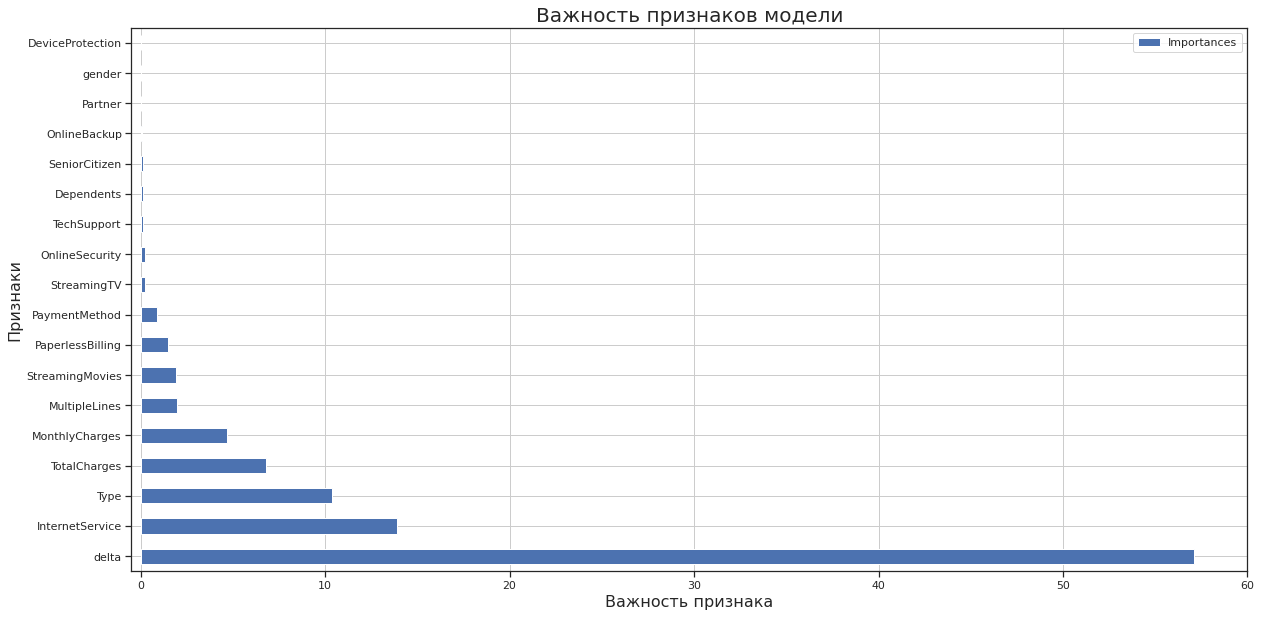

In [39]:
train_dataset = Pool(features_train,
                     target_train,
                     cat_features=['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
                                   'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
                                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                                   'StreamingMovies', 'MultipleLines'])
feature_importance = model_CBC.get_feature_importance(train_dataset, prettified = True)
display(feature_importance)


feature_importance.plot.barh(x='Feature Id', y='Importances', figsize=(20,10));
plt.xlim([-0.5, 60])
plt.xlabel('Важность признака', fontsize=16)
plt.ylabel('Признаки', fontsize=16)
plt.title('Важность признаков модели', fontsize=20)
plt.grid();

Самым важным признаком является delta - время, которое клиент пользовался услугами компании. Затем идут InternetService и Type, TotalCharges и MonthlyCharges. Отсальные признаки сильно менее важны.

## Выводы

Данные были загружены, объединены в одну таблицу и проанализированы. В нескольких стролбцах изменены типы данных, пропущенные значения заполнены.

На этапе подготовки к построению модели на основе столбца EndDate был создан целевой столбец.
Также был создан дополнительный признак - столбец delta (на основе столбцов BeginDate и EndDate). Это кол-во дней, которое пользователь пользуется услугами компании. После были удалены столбцы BeginDate и EndDate. 

Далее данные были поделены на тренировочный и тестовый датасеты в отношении 75/25 со стратификацией 
и закодированы, посредством OneHotEncoder. 

Были обучены модели LogisticRegression, RandomForestClassifier и CatBoostClassifier. Гиперпараметры подбирались с помощью гридсерча.

После модели сравнивались между собой, лучшей была выбрана модель CatBoostClassifier с гиперпараметрами:
- depth=1
- n_estimators=2000
- learning_rate=1.

Затем модель прогонялась через тестовые данные, на которых метрика roc-auc достигла значения 0.9. Были построены roc-кривые и матрица ошибок. Также был проведен анализ важности признаков - наиболее важными признаками являются - время, которое клиент пользовался услугами компании (delta), наличие подключения к интернету (InternetService) и его тип (Type), а также итоговая и помесячная сумма платежа (TotalCharges и MonthlyCharges).